# 1. Prepare

## 1.1. Settings

In [1]:
from keras import optimizers
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, merge
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import  Lambda
from keras import backend as K
from keras.backend import set_image_data_format
from keras.utils.layer_utils import convert_all_kernels_in_model

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time

%config InlineBackend.figure_format = 'retina'
set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
input_size = 227
batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 40

cpu_threads = 8

## 1.2. Data and augmentaion

In [3]:
train_directory = './data/train'
validation_directory = './data/validation'
test_directory = './data/test'

In [51]:
def mean_subtract(x):
    x[0, :, :] -= 123.68
    x[1, :, :] -= 116.779
    x[2, :, :] -= 103.939
    x /= 255.

    return x

datagen = ImageDataGenerator(
    preprocessing_function=mean_subtract,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validgen = ImageDataGenerator(preprocessing_function=mean_subtract)

testgen = ImageDataGenerator(preprocessing_function=mean_subtract)

train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = validgen.flow_from_directory(
    validation_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size_val,
    shuffle=True)

test_generator = testgen.flow_from_directory(
    test_directory,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 24561 images belonging to 7 classes.
Found 11074 images belonging to 7 classes.
Found 1289 images belonging to 7 classes.


## 1.3. Model

In [5]:
# based on
# https://github.com/lunardog/convnets-keras
# https://github.com/heuritech/convnets-keras/issues/17#issuecomment-308997304

In [6]:
def crosschannelnormalization(alpha = 1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        K.set_image_dim_ordering('th')
        if K.backend()=='tensorflow':
            b, ch, r, c = X.get_shape()
        else:
            b, ch, r, c = X.shape
        half = n // 2
        square = K.square(X)
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0,2,3,1))
                                              , ((0,0),(half,half)))
        extra_channels = K.permute_dimensions(extra_channels, (0,3,1,2))
        scale = k
        for i in range(n):
            if K.backend()=='tensorflow':
                ch = int(ch)
            scale += alpha * extra_channels[:,i:i+ch,:,:]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape:input_shape,**kwargs)

def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        if K.backend()=='tensorflow':
            div = int(X.get_shape()[axis]) // ratio_split
        else:
            div = X.shape[axis] // ratio_split

        if axis == 0:
            output =  X[id_split*div:(id_split+1)*div,:,:,:]
        elif axis == 1:
            output =  X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:,:,id_split*div:(id_split+1)*div,:]
        elif axis == 3:
            output = X[:,:,:,id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")

        return output

    def g(input_shape):
        output_shape=list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)

    return Lambda(f,output_shape=lambda input_shape:g(input_shape),**kwargs)

In [7]:
def AlexNet(weights_path=None, num_classes=1000, input_size=227):
    inputs = Input(shape=(3, input_size, input_size))

    conv_1 = Conv2D(96, (11, 11), strides=(4, 4),activation='relu', name='conv_1')(inputs)

    conv_2 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Conv2D(128, (5, 5), activation='relu', name='conv_2_'+str(i+1))(
            splittensor(ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=1, name='conv_2')

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1,1))(conv_3)
    conv_3 = Conv2D(384, (3, 3), activation='relu', name='conv_3')(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3)
    conv_4 = merge([
        Conv2D(192, (3, 3), activation='relu', name='conv_4_'+str(i+1))(
            splittensor(ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=1, name='conv_4')

    conv_5 = ZeroPadding2D((1, 1))(conv_4)
    conv_5 = merge([
        Conv2D(128, (3, 3), activation='relu', name='conv_5_'+str(i+1))(
            splittensor(ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=1, name='conv_5')

    dense_1 = MaxPooling2D((3, 3), strides=(2,2),name="convpool_5")(conv_5)

    dense_1 = Flatten(name='flatten')(dense_1)
    dense_1 = Dense(4096, activation='relu',name='dense_1')(dense_1)
    dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(4096, activation='relu',name='dense_2')(dense_2)
    dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(num_classes, name='dense_3')(dense_3)
    predictions = Activation('softmax', name='softmax')(dense_3)

    model = Model(inputs=inputs, outputs=predictions)

    if weights_path:
        model.load_weights(weights_path)
        
        print('Weights loaded.')

        if K.backend() == 'tensorflow':
            convert_all_kernels_in_model(model)

    return model

In [8]:
base_model = AlexNet(weights_path='./AlexNet/alexnet_weights.h5')

# base_model.summary()

x = base_model.get_layer('dense_1').output
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='dense_2')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, name='dense_3')(x)
predictions = Activation('softmax', name='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

/home/marcin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/home/marcin/.local/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/marcin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/marcin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Weights loaded.


## Load weights form numpy(old)

In [9]:
# net_weights = np.load(open('./AlexNet/bvlc_alexnet.npy', 'rb')).item()
# for layer in ['conv1', 'conv2' , 'conv3' , 'conv4' , 'conv5', 'fc6', 'fc7', 'fc8']:
#     w = net_weights[layer][0]
#     b = net_weights[layer][1]
#     print(w.shape)

In [10]:
# for layer in ['conv1', 'conv2' , 'conv3' , 'conv4' , 'conv5', 'fc6', 'fc7', 'fc8']:
#     weights = np.load(open('./AlexNet/{}w.npy'.format(layer), 'rb'))
#     biases = np.load(open('./AlexNet/{}b.npy'.format(layer), 'rb'))
#     print(layer)
#     print(weights.shape)
#     print(model.get_layer(layer).get_weights()[0].shape)
# #     print(model.get_layer(layer).get_config())
    
    
# #     model.get_layer(layer).set_weights((weights.transpose(3, 2, 1, 0), biases))

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [11]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/phase_1_alexnet.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/phase_1_alexnet.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/phase_1_alexnet',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
1535/1535 [==============================] - 158s - loss: 1.0145 - acc: 0.6886 - val_loss: 0.5792 - val_acc: 0.8022
Epoch 2/10
1535/1535 [==============================] - 80s - loss: 0.8271 - acc: 0.7305 - val_loss: 0.6014 - val_acc: 0.8077
Epoch 3/10
1535/1535 [==============================] - 81s - loss: 0.8029 - acc: 0.7448 - val_loss: 0.6995 - val_acc: 0.7733
Epoch 4/10
1535/1535 [==============================] - 82s - loss: 0.8003 - acc: 0.7497 - val_loss: 0.4991 - val_acc: 0.8398
Epoch 00003: early stopping


Load best epoch:

In [43]:
model.load_weights('./output/checkpoints/phase_1_alexnet.h5')

## 2.2. Phase 2
Train all layers.

In [32]:
for layer in model.layers[17:]:
    layer.trainable = True

In [45]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-3, nesterov=True),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/phase_2_alexnet.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/phase_2_alexnet.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/phase_2_alexnet',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/40
1535/1535 [==============================] - 190s - loss: 0.6899 - acc: 0.7618 - val_loss: 0.4227 - val_acc: 0.8498
Epoch 2/40
1535/1535 [==============================] - 141s - loss: 0.5312 - acc: 0.8167 - val_loss: 0.3913 - val_acc: 0.8533
Epoch 3/40
1535/1535 [==============================] - 124s - loss: 0.4571 - acc: 0.8384 - val_loss: 0.3383 - val_acc: 0.8796
Epoch 4/40
1535/1535 [==============================] - 123s - loss: 0.4063 - acc: 0.8544 - val_loss: 0.2748 - val_acc: 0.9021
Epoch 5/40
1535/1535 [==============================] - 122s - loss: 0.3767 - acc: 0.8693 - val_loss: 0.2436 - val_acc: 0.9184
Epoch 6/40
1535/1535 [==============================] - 124s - loss: 0.3511 - acc: 0.8772 - val_loss: 0.2655 - val_acc: 0.9016
Epoch 7/40
1535/1535 [==============================] - 135s - loss: 0.3295 - acc: 0.8858 - val_loss: 0.2214 - val_acc: 0.9259
Epoch 8/40
1535/1535 [==============================] - 144s - loss: 0.3036 - acc: 0.8965 - val_loss: 0.2124 - 

Load best epoch:

In [46]:
model.load_weights('./output/checkpoints/phase_2_alexnet.h5')

# 3. Evaluate

## 3.1. Evaluate

In [47]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.2f}'.format(score[1]))

Test accuracy: 0.94


## 3.2. Propagation time

In [52]:
t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Propagation time of 1289 images: 5757.849 ms (4.467 ms per image)


## 3.3. Confusion matrix

In [53]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

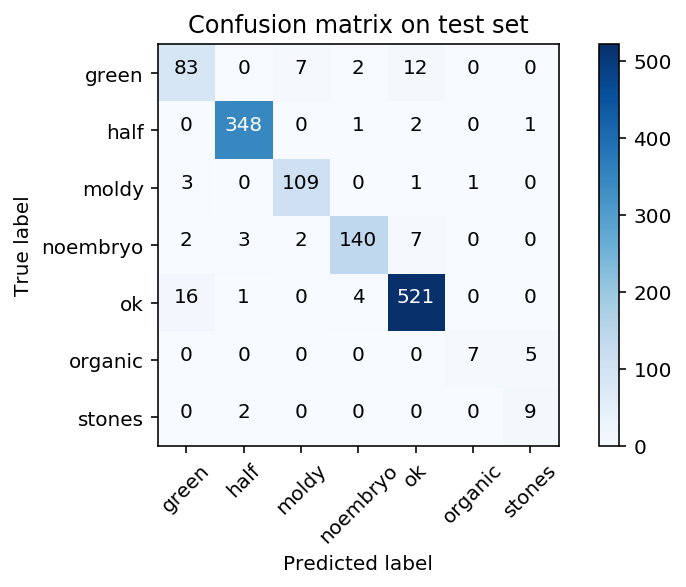

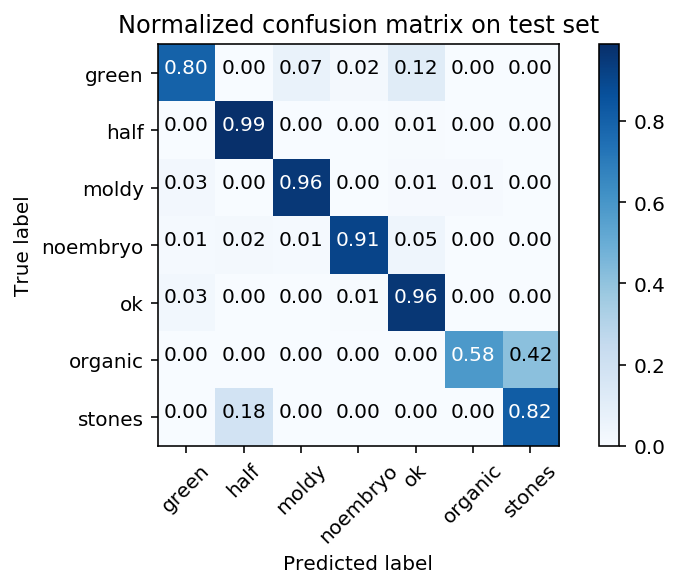

In [54]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()